# Assignment 5

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* Please note that in this assignment, students are expected to work independently. As a result, no two solutions should look identical in terms of coding.
---

``Objective``
* Perform multiclass classification using logistic regression. <span style="color:chocolate"> You will choose the outcome of interest. </span>

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task. 


``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [1]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
from matplotlib import pyplot as plt

import matplotlib as mpl
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import pprint


2024-06-16 23:12:11.648699: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-16 23:12:11.649039: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-16 23:12:11.652381: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-16 23:12:11.693595: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 23:12:12.408790: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

### Define functions

In [2]:
def read_data():
    ''''''
    # Read data
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",
        sep=",",
        encoding='latin-1'
    )
    
    return df

In [3]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15
    
    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

---
### Step 1: Data ingestion

First, we'll initiate the process of discovering the chocolate world by loading the data. Then, to assist with this assignment, we'll start by tidying up the data a little bit. This involves renaming columns and conducting some string preprocessing tasks, which will be handled by the <span style="color:chocolate">clean_data()</span> function mentioned earlier.

In [4]:
df = clean_data(read_data())
print('Shape of data', df.shape)
df.head()

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


### <span style="color:chocolate">Exercise 1:</span> Getting to know the data (5 points)

Answer the following questions:
    
1. How many columns does the dataset contain?
2. How many rows are there in the dataset?
3. What are the column names?
4. List the number of unique values for each column in the data;
5. What do the reference and rating numbers represent? (Hint: read the dataset documentation and write down the interpretation for each number).

In [5]:
print('1. Columns in data =', df.shape[1])
print('2. Rows in data =', df.shape[0])
print('3. Columnn names = ', df.columns.to_list())

print('4. Number of unique values by column:')
for col in df.columns:
    print('\tColumn:', col,'- number of unique vals =', len(df[col].unique()))

print("""\n5. The reference numbers are values associated with when the data was recorded
in the database - the higher the number, the more recent the data record.

The rating is on a scale of 1 to 5 with 5 being a the highest quality chocolate,
3.75 being 'praiseworthy', 3 being 'satsifactory' chocolate, and 1 being unpalatable. 
This is an expert review of one sample of chocolate from one batch and is a 
combination of objective and subjective measures.
""")


1. Columns in data = 9
2. Rows in data = 1795
3. Columnn names =  ['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin']
4. Number of unique values by column:
	Column: maker - number of unique vals = 414
	Column: specific_origin - number of unique vals = 1038
	Column: reference_number - number of unique vals = 440
	Column: review_date - number of unique vals = 12
	Column: cocoa_percent - number of unique vals = 45
	Column: maker_location - number of unique vals = 58
	Column: rating - number of unique vals = 13
	Column: bean_type - number of unique vals = 39
	Column: broad_origin - number of unique vals = 160

5. The reference numbers are values associated with when the data was recorded
in the database - the higher the number, the more recent the data record.

The rating is on a scale of 1 to 5 with 5 being a the highest quality chocolate,
3.75 being 'praiseworthy', 3 being 'satsifactory' chocolate, and 

### <span style="color:chocolate">Exercise 2:</span> Choosing the prediction task (5 points)

Now that you've familiarized yourself with the data a little bit, select a multiclass outcome you're interested in predicting. Note: the outcome should have <span style="color:chocolate">at least 3 classes</span>!

Intuition: conducting a multi-class classification on this chocolate dataset can be incredibly valuable for several reasons: customer preferences and personalization, market analysis, R&D, etc.

Your answer here: We are creating 3 classes of ratings for customers - low quality (rating below 3.0), satisfactory (rating greater than or equal to 3.0 and less than 3.75), and high quality (rating greater than or equal to 3.75). We will use 3.75 as the cutoff for "high" since 3.75 is considered "praiseworthy".

---
### Step 2: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 3:</span> Plots (20 points)

In line with the structure of previous assignments, execute the following steps:

1. Generate a minimum of 4 plots to investigate features within the dataset and the chosen outcome;
2. Ensure that each plot includes clear axis labels and titles;
3. Provide commentary on the insights learned from your visualizations.

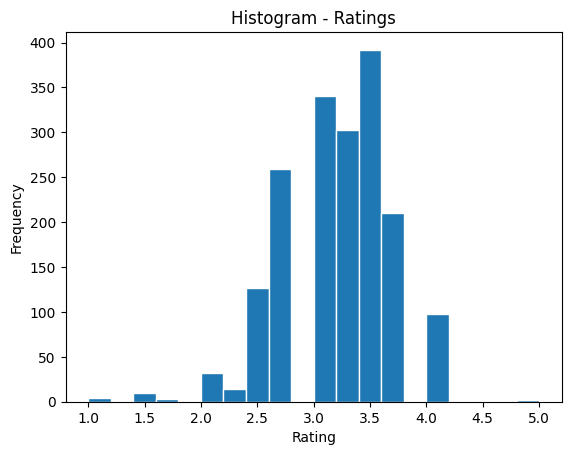


Most of the ratings are between 3.0 and 3.75. There are very few in the 4.0+ range
meaning only an exceptional few chocolates are deemed 'elite'. There are a 
meaningful amount below the 3.0 rating, meaning there are many chocolates not deemed
satisfactory. When creating the classifications for ratings, we will not be able to 
create classes for the 4.0 to 5.0 or the 1.0 to 2.0 ratings becuase it is likely that 
there are too few examples for us to meaningfully distinguish.



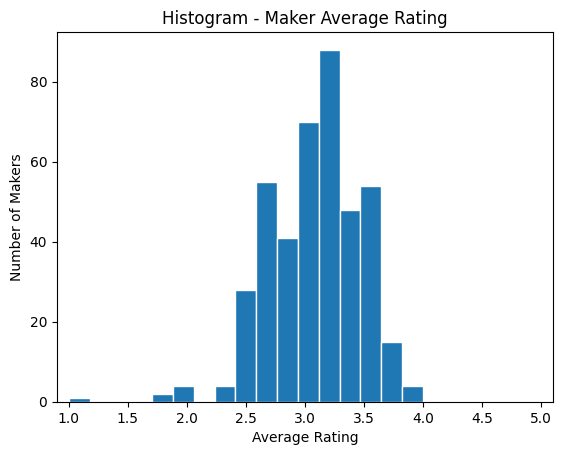


The distribution of the average ratings for the makers is much tighter around the 3.0 
rating than the distribution for the individual ratings. This relatively smaller 
variance means that the maker may contribute a small amount to the overall distinction 
of the ratings when trying to separate out the low quality chocolates from the rest.



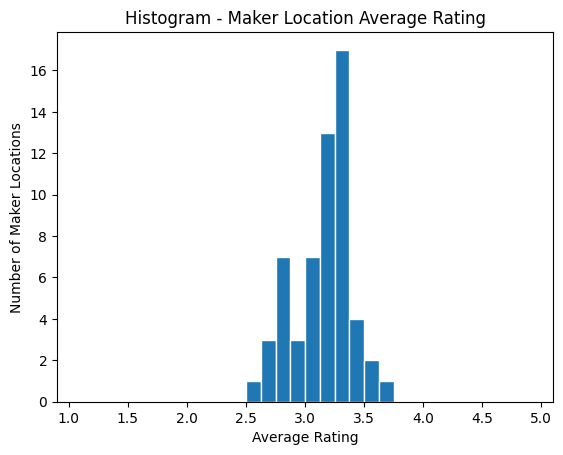


The distribution of the average ratings for the maker lcoations is even tighter around 
the 3.0 rating than the prior distribution for the individual makers. This relatively smaller 
variance means that the maker location may contribute a small amount to the overall distinction 
of the ratings when trying to separate out the low quality chocolates from the rest.



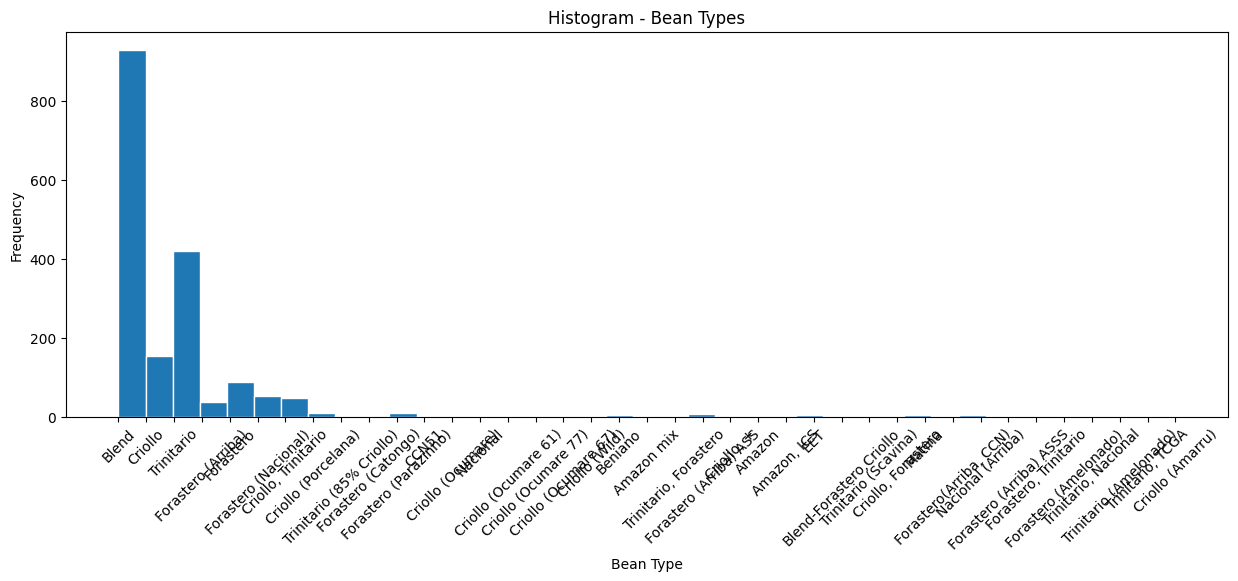


Most of the chocolates (~85%) come from the top 3 bean types - Blend, Trinitario, and Criollo.



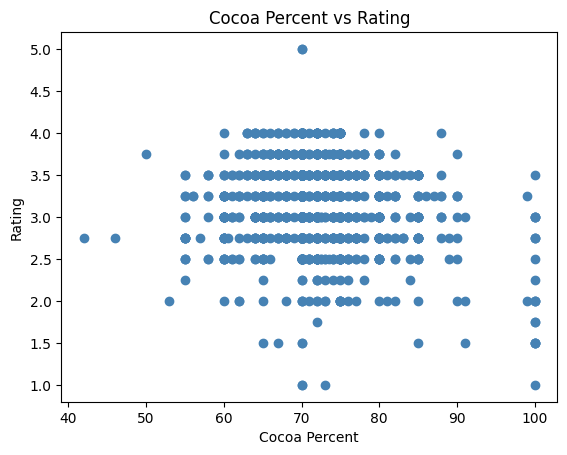


There is not a clear linear relationship between the percent of cocoa and the rating of 
the chocolate. Chocolates with 100% cocoa have ratings from 1.0 to 3.5. This tells us 
that this feature will likely a small amount to the classification of 
chocolates.



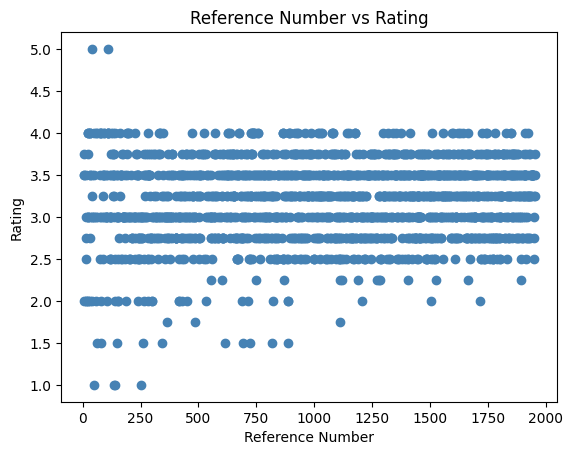


There is not a clear linear relationship between the reference number and the rating of 
the chocolate. There seems to be a wider range of ratings for lower reference numbers
(near 0), and the ratings for higher reference numbers are concentrated around 3 with
fewer in the lower rating range.



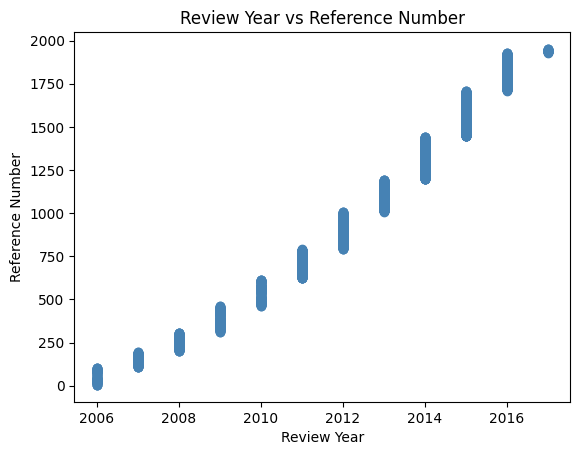


The Reference Number is clearly correlated with the review year, confirming the 
documentation. These two fields would be redundant.



In [6]:
# Plot 1 - Histogram of Ratings
plt.hist(df['rating'], bins=20, edgecolor='white')
plt.title('Histogram - Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

print("""
Most of the ratings are between 3.0 and 3.75. There are very few in the 4.0+ range
meaning only an exceptional few chocolates are deemed 'elite'. There are a 
meaningful amount below the 3.0 rating, meaning there are many chocolates not deemed
satisfactory. When creating the classifications for ratings, we will not be able to 
create classes for the 4.0 to 5.0 or the 1.0 to 2.0 ratings becuase it is likely that 
there are too few examples for us to meaningfully distinguish.
""")

# Plot 2 - Histogram of maker rating averages
rating_avg_by_maker = df.groupby('maker')['rating'].mean()

plt.hist(rating_avg_by_maker, bins=17, edgecolor='white')
plt.title('Histogram - Maker Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Number of Makers')
plt.xlim((0.9, 5.1))
plt.show()

print("""
The distribution of the average ratings for the makers is much tighter around the 3.0 
rating than the distribution for the individual ratings. This relatively smaller 
variance means that the maker may contribute a small amount to the overall distinction 
of the ratings when trying to separate out the low quality chocolates from the rest.
""")

# Plot 3 - Histogram of maker location rating averages
rating_avg_by_maker_location = df.groupby('maker_location')['rating'].mean()

plt.hist(rating_avg_by_maker_location, bins=10, edgecolor='white')
plt.title('Histogram - Maker Location Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Number of Maker Locations')
plt.xlim((0.9, 5.1))
plt.show()

print("""
The distribution of the average ratings for the maker lcoations is even tighter around 
the 3.0 rating than the prior distribution for the individual makers. This relatively smaller 
variance means that the maker location may contribute a small amount to the overall distinction 
of the ratings when trying to separate out the low quality chocolates from the rest.
""")

# Plot 4 - Histogram of bean types
bins = len(df['bean_type'].unique())

plt.figure(figsize=(15, 5))

plt.hist(df['bean_type'], bins=bins, edgecolor='white')
plt.title('Histogram - Bean Types')
plt.xlabel('Bean Type')
plt.xticks(rotation = 45)
plt.ylabel('Frequency')
plt.show()

print("""
Most of the chocolates (~85%) come from the top 3 bean types - Blend, Trinitario, and Criollo.
""")

# Plot 5 - Scatter of Ratings v Cocoa Percent
plt.scatter(df['cocoa_percent'], df['rating'],
           c='steelblue', marker='o')
plt.title('Cocoa Percent vs Rating')
plt.xlabel('Cocoa Percent')
plt.ylabel('Rating')
plt.show()

print("""
There is not a clear linear relationship between the percent of cocoa and the rating of 
the chocolate. Chocolates with 100% cocoa have ratings from 1.0 to 3.5. This tells us 
that this feature will likely a small amount to the classification of 
chocolates.
""")

# Plot 6 - Scatter of Ratings v Reference Number
plt.scatter(df['reference_number'], df['rating'],
           c='steelblue', marker='o')
plt.title('Reference Number vs Rating')
plt.xlabel('Reference Number')
plt.ylabel('Rating')
plt.show()

print("""
There is not a clear linear relationship between the reference number and the rating of 
the chocolate. There seems to be a wider range of ratings for lower reference numbers
(near 0), and the ratings for higher reference numbers are concentrated around 3 with
fewer in the lower rating range.
""")

# Plot 7 - Scatter of Reference Number v Review Date
plt.scatter(df['review_date'], df['reference_number'],
           c='steelblue', marker='o')
plt.title('Review Year vs Reference Number')
plt.xlabel('Review Year')
plt.ylabel('Reference Number')
plt.show()

print("""
The Reference Number is clearly correlated with the review year, confirming the 
documentation. These two fields would be redundant.
""")


---
### Step 3: Data preprocessing

### <span style="color:chocolate">Exercise 4:</span> Prepare data for modeling (20 points)

Following the format of previous assignments, adhere to the following steps as a minimum:

1. Identify the features of interest;
2. Perform necessary cleaning on the features;
3. Reassess the outcome variable if desired (e.g., potentially reducing the number of classes, while ensuring a minimum of 3);
4. Shuffle the dataset;
5. Create training, validation, and test datasets using a 60/20/20 split;
6. Standardize the data;
7. Integrate any supplementary tasks deemed crucial for modeling, especially considering the chosen outcome variable.

In [7]:
# gather the features and labels to model
model_cols =  ['maker', 'review_date', 'broad_origin', 'rating']
model_df = df[model_cols]

# rename values in broad_origin to the continent to reduce number of unique values
print('Original Broad Origin Vals:')
print(model_df['broad_origin'].unique())

broad_origin_dict = {
    'Sao Tome': 'Africa',
    'Togo': 'Africa',
    'Peru': 'South America',
    'Venezuela': 'South America',
    'Cuba': 'Caribbean',
    'Panama': 'Central America',
    'Madagascar': 'Africa',
    'Brazil': 'South America',
    'Ecuador': 'South America',
    'Colombia': 'South America',
    'Burma': 'Asia',
    'Papua New Guinea': 'Oceania',
    'Bolivia': 'South America',
    'Fiji': 'Oceania',
    'Mexico': 'North America',
    'Indonesia': 'Asia',
    'Trinidad': 'Caribbean',
    'Vietnam': 'Asia',
    'Nicaragua': 'Central America',
    'Tanzania': 'Africa',
    'Dominican Republic': 'Caribbean',
    'Ghana': 'Africa',
    'Belize': 'Central America',
    'Nine': 'Unknown',
    'Jamaica': 'Caribbean',
    'Grenada': 'Caribbean',
    'Toscano Black': 'Unknown',
    'Guatemala': 'Central America',
    'Honduras': 'Central America',
    'Costa Rica': 'Central America',
    'Haiti': 'Caribbean',
    'Congo': 'Africa',
    'Philippines': 'Asia',
    'Houseblend': 'Unknown',
    'Malaysia': 'Asia',
    'Nature': 'Unknown',
    'Dominican Republic,Bali': 'Multiple',
    'Organic Dark': 'Unknown',
    'Venezuela,Africa,Brasil,Peru,Mexico': 'Multiple',
    'Gabon': 'Africa',
    'Ivory Coast': 'Africa',
    'Carribean': 'Caribbean',
    'One Hundred': 'Unknown',
    'Sri Lanka': 'Asia',
    'Blend': 'Unknown',
    'Puerto Rico': 'Caribbean',
    'Lago di Como,Blu': 'Europe',
    'Uganda': 'Africa',
    'Blend No 1': 'Unknown',
    'Philly Blend,5 plantations': 'Unknown',
    'Kendari': 'Asia',
    'Tarakan': 'Asia',
    'Maragda': 'Unknown',
    'Martinique': 'Europe',
    'Sao Tome,Principe': 'Africa',
    'Sensations Intense': 'Unknown',
    'Vanuatu': 'Oceania',
    'Australia': 'Oceania',
    'Zorzal Reserva,2015 H,Kerchner': 'Unknown',
    'Liberia': 'Caribbean',
    'Ecuador,Costa Rica': 'Multiple',
    'West Africa': 'Africa',
    'Hawaii': 'North America',
    'Noir': 'Unknown',
    'Ilblend': 'Unknown',
    'St Lucia': 'Caribbean',
    'Costa Rica,Venezuela': 'Multiple',
    'Peru,Madagascar': 'Multiple',
    'Red Vanilla': 'Unknown',
    'Venezuela,Trinidad': 'Multiple',
    'Supremo,SF': 'Unknown',
    'Dark': 'Unknown',
    'Trinidad,Tobago': 'Caribbean',
    'Venezuela,Trinidad,Ecuador': 'Multiple',
    'Epique,Blend No 49': 'Unknown',
    'Coucher du Soleil': 'Unknown',
    'Lever du Soleil': 'Unknown',
    'Onyx': 'Unknown',
    'Nocturne': 'Unknown',
    'Complexite': 'Unknown',
    'Special Maker Reserve': 'Unknown',
    'Quetzalcoatl': 'North America',
    'Tsaranta': 'Unknown',
    'Semisweet': 'Unknown',
    'Campesino w,nibs': 'Unknown',
    'Trinitario': 'Unknown',
    'Downtown London': 'Europe',
    'Africa meets Latina': 'Africa',
    'Amazonas': 'South America',
    'one hundred': 'Unknown',
    'South America,Africa': 'Multiple',
    'India': 'Asia',
    'Africa,Carribean,Central America': 'Multiple',
    'Tobago': 'Caribbean',
    'Kuruba': 'Asia',
    'Orinoco': 'South America',
    'Venezuela,Indonesia,Ecuador': 'Multiple',
    'Peru,Ecuador,Venezuela': 'South America',
    'Venezuela,Dominican Republic': 'Multiple',
    'Excellence ,US Version': 'North America',
    'Colombia,Ecuador': 'South America',
    'Solomon Islands': 'Oceania',
    'Cacao Nib Crunch': 'Unknown',
    'Nigeria': 'Africa',
    'Peru,Belize': 'South America',
    'Peru,Madagascar,Dominican Republic': 'Multiple',
    'Brooklyn Blend': 'North America',
    'Papua New Guinea,Vanuatu,Madagascar': 'Multiple',
    'El Salvador': 'South America',
    'South America': 'South America',
    'Carre Amer': 'Unknown',
    'Carre Grand Noir': 'Unknown',
    'Noir Infini': 'Unknown',
    'Samoa': 'Oceania',
    'Ghana,Dominican Republic': 'Multiple',
    'Grand Cru Blend No1,5 yr Anniversary Ed': 'Unknown',
    'Trinidad,Ecuador': 'Multiple',
    'Signature Blend': 'Unknown',
    'Cameroon': 'Africa',
    'Venezuela,Java': 'Multiple',
    'Venezuela,Ghana': 'Multiple',
    'Indonesia,Ghana': 'Multiple',
    'Peru,SMartin,Pangoa,nacional': 'Multiple',
    'Raw': 'Unknown',
    'Mid Mountain,2014': 'Unknown',
    'Principe': 'Caribbean',
    '100 percent': 'Unknown',
    'Latino': 'Unknown',
    'Central,South America': 'Multiple',
    'Venezuela,Trinidad,Madagascar': 'Multiple',
    'Carribean,Dominican Republic,Jamaica,Trinidad': 'Caribbean',
    'Nibby': 'Unknown',
    'Extra Dark': 'Unknown',
    'Bittersweet': 'Unknown',
    'Ghana,Madagascar': 'Multiple',
    'Wasatch': 'North America',
    'Venezuela,Ecuador,Peru,Nicaragua': 'South America',
    'Madagascar,Ecuador': 'Multiple',
    "Chef's Blend": 'Unknown',
    'Guatemala,Dominican Republic,Peru,Madagascar,Papua New Guinea': 'Multiple',
    'Peru,Dominican Republic': 'Multiple',
    'Dominican Republic,Madagascar': 'Multiple',
    'Grenada,Papua New Guinea,Hawaii,Haiti,Madagascar': 'Multiple',
    'Madagascar,Java,Papua New Guinea': 'Multiple',
    'Venezuela,Bolivia,Dominican Republic': 'Multiple',
    'Dominican Republic,Ecuador,Peru': 'Multiple',
    'Suriname': 'Africa',
    'Peru,Ecuador': 'South America',
    'TCHOPro 605': 'Unknown',
    'TCHOPro 68': 'Unknown',
    'Ecuador,Madagascar,Papua New Guinea': 'Multiple',
    'Ghana,Panama,Ecuador': 'Multiple',
    'Andoa,Grand Cru blend': 'Unknown',
    'Caraque': 'Unknown',
    'Venezuela,Carribean': 'Multiple',
    'Le Noir Extra Amer': 'Unknown',
    'House Blend,Batch 2': 'Unknown',
    'Goddess Blend': 'Unknown',
    'Amazonas Frucht': 'Unknown',
    'Indianer,Raw': 'Unknown'
}

model_df['broad_origin'].replace(broad_origin_dict, inplace=True)

print('New Broad Origin Vals:')
print(model_df['broad_origin'].unique())

# normalize cocoa_percent
if 'cocoa_percent' in model_df.columns:
    cocoa_percent_max = model_df['cocoa_percent'].max()
    cocoa_percent_min = model_df['cocoa_percent'].min()

    model_df['cocoa_percent_norm'] = (model_df['cocoa_percent'] - cocoa_percent_min) / (cocoa_percent_max - cocoa_percent_min)

# normalize reference_number
if 'reference_number' in model_df.columns:
    reference_number_max = model_df['reference_number'].max()
    reference_number_min = model_df['reference_number'].min()
    
    model_df['reference_number_norm'] = (model_df['reference_number'] - reference_number_min) / (reference_number_max - reference_number_min)

# onehot encode columns
onehot_cols_all = ['maker', 'maker_location', 'bean_type', 'specific_origin', 'broad_origin', 'review_date']
onehot_cols = [col for col in model_cols if col in onehot_cols_all]
for col in onehot_cols:
    onehot_df = pd.get_dummies(
        model_df[col],
        dtype=int,
        drop_first=False
        )
    model_df = pd.concat([model_df, onehot_df],
              axis=1)

# create classifications for Y/rating
def classify_rating(x, cutoff_low, cutoff_hi):
    if x < cutoff_low:
        return 0
    elif x >= cutoff_hi:
        return 2
    else:
        return 1

# set rating cutoffs
cutoff_low = 3
cutoff_hi = 3.75

model_df['rating_class'] = model_df['rating'].apply(lambda x: classify_rating(x, cutoff_low, cutoff_hi))

# get X dataframe
#drop_cols = ['maker', 'cocoa_percent', 'maker_location', 'bean_type', 'broad_origin', 'rating', 'rating_class']
drop_cols = ['maker', 'broad_origin', 'review_date', 'rating', 'rating_class']
X = model_df.drop(drop_cols, axis=1).values
print('X:')
print('Shape =', X.shape)
print(X[:5])

# get Y dataframe
Y = model_df['rating_class'].values
print('-'*50)
print('Y:')
print('Shape =', Y.shape)
print('Vals:')
pprint.pp(dict(Counter(Y)))


####################
# shuffle data
np.random.seed(1234)
splits = (0.6, 0.2, 0.2)
shuffle = np.random.permutation(np.arange(Y.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# split data
splits = np.multiply(len(Y), splits).astype(int)
X_train, X_val, X_test = np.split(X, [splits[0], splits[0]+splits[1]])
Y_train, Y_val, Y_test = np.split(Y, [splits[0], splits[0]+splits[1]])

# convert Y sets to one-hot
Y_train_dense = tf.keras.utils.to_categorical(Y_train)
Y_val_dense = tf.keras.utils.to_categorical(Y_val)
Y_test_dense = tf.keras.utils.to_categorical(Y_test)

print('-'*50)
print('Size of X_train', X_train.shape)
print('Size of Y_train', Y_train_dense.shape)
print('Size of X_val', X_val.shape)
print('Size of Y_val', Y_val_dense.shape)
print('Size of X_test', X_test.shape)
print('Size of Y_test', Y_test_dense.shape)


Original Broad Origin Vals:
['Sao Tome' 'Togo' 'Peru' 'Venezuela' 'Cuba' 'Panama' 'Madagascar'
 'Brazil' 'Ecuador' 'Colombia' 'Burma' 'Papua New Guinea' 'Bolivia' 'Fiji'
 'Mexico' 'Indonesia' 'Trinidad' 'Vietnam' 'Nicaragua' 'Tanzania'
 'Dominican Republic' 'Ghana' 'Belize' 'Nine' 'Jamaica' 'Grenada'
 'Toscano Black' 'Guatemala' 'Honduras' 'Costa Rica' 'Haiti' 'Congo'
 'Philippines' 'Houseblend' 'Malaysia' 'Nature' 'Dominican Republic,Bali'
 'Organic Dark' 'Venezuela,Africa,Brasil,Peru,Mexico' 'Gabon'
 'Ivory Coast' 'Carribean' 'One Hundred' 'Sri Lanka' 'Blend' 'Puerto Rico'
 'Lago di Como,Blu' 'Uganda' 'Blend No 1' 'Philly Blend,5 plantations'
 'Kendari' 'Tarakan' 'Maragda' 'Martinique' 'Sao Tome,Principe'
 'Sensations Intense' 'Vanuatu' 'Australia'
 'Zorzal Reserva,2015 H,Kerchner' 'Liberia' 'Ecuador,Costa Rica'
 'West Africa' 'Hawaii' 'Noir' 'Ilblend' 'St Lucia' 'Costa Rica,Venezuela'
 'Peru,Madagascar' 'Red Vanilla' 'Venezuela,Trinidad' 'Supremo,SF' 'Dark'
 'Trinidad,Tobago' 'Venez

/tmp/ipykernel_25229/2854057204.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['broad_origin'].replace(broad_origin_dict, inplace=True)


---
### Step 4: Exploratory data analysis (EDA) - cont'd

### <span style="color:chocolate">Exercise 5:</span> More plots (5 points)

Conduct any further exploratory data analysis (EDA) you believe necessary to validate the successful preprocessing of the data.

NAs in X: 0
NAs in Y: 0
Freq counts for broad_origin:
{'Africa': 267,
 'South America': 741,
 'Caribbean': 288,
 'Central America': 197,
 'Asia': 72,
 'Oceania': 66,
 'North America': 62,
 'Unknown': 61,
 'Multiple': 38,
 'Europe': 3}


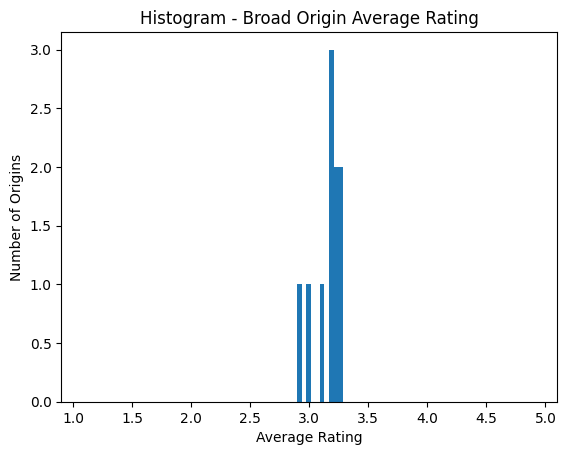

Label counts:
{2: 175, 1: 621, 0: 281}


In [8]:
print('NAs in X:', np.isnan(X).sum())
print('NAs in Y:', np.isnan(Y).sum())

# check frequency of new broad origin
if 'broad_origin' in model_df.columns:
    print('Freq counts for broad_origin:')
    pprint.pp(dict(Counter(model_df['broad_origin'])))
    
    # Plot - Histogram of broad origin rating averages
    rating_avg_by_broad_origin = model_df.groupby('broad_origin')['rating'].mean()
    
    plt.hist(rating_avg_by_broad_origin)
    plt.title('Histogram - Broad Origin Average Rating')
    plt.xlabel('Average Rating')
    plt.ylabel('Number of Origins')
    plt.xlim((0.9, 5.1))
    plt.show()


# check frequency of labels
print('Label counts:')
pprint.pp(dict(Counter(Y_train)))
    

---
### Step 5: Modeling

### <span style="color:chocolate">Exercise 6:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

1. Implement this baseline and report the accuracy metric on the train data;

2. Implement a function that computes the Log Loss (cross-entropy loss) metric and use it to evaluate this baseline on both the train and validation data. Note: reflect on what you know about the original distribution of classes in your training data (Hint: see Assignment 4 - Exercise 8 and ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example).

In [9]:
# create the baseline prediction using the majority class
n_train_samples = Y_train.shape[0]
n_labels = len(model_df['rating_class'].unique())
train_label_freq = dict(Counter(Y_train))
pred_baseline_dense = [train_label_freq[i]/n_train_samples for i in range(n_labels)]
print('Baseline predictions:',pred_baseline_dense)

# create function for cross-entropy loss
def ce_loss(preds, Y):
  """
    preds are (m,n) m = number of examples, n = number of classes
    Y is (m,) -- array of sparse labels 
    preds[0] = [.1, .1, .8] Y[0] = 2 Y_dense[0] = [0, 0, 1]
  """
  # Get the number of examples
  m = Y.shape[0]

  # Compute the first sum, the cross-entropy for each example, using
  # the rows of the predictions and corresponding labels.
  # Note that we need the dense (one-hot) labels.
  Y_dense = tf.keras.utils.to_categorical(Y)
  # [.1, .1, .8] [0, 0, 1] -> [0, 0, -1*log(.8)] -> -1*log(.8)
  cross_entropy_values = - np.sum(Y_dense * np.log(preds), axis=1)

  # Here's a more efficient but tricky way to do this:
  # cross_entropy_values = -np.log(preds[range(m), Y])

  # Sum the per-example cross-entropy values.
  loss = np.sum(cross_entropy_values) / m

  return loss

# create predictions using baseline
y_hat_train_baseline_dense = np.array([pred_baseline_dense for i in range(len(Y_train_dense))])
y_hat_val_baseline_dense = np.array([pred_baseline_dense for i in range(len(Y_val_dense))])

# get labels
y_hat_train_baseline_labels = np.argmax(y_hat_train_baseline_dense, axis=1)
y_hat_val_baseline_labels = np.argmax(y_hat_val_baseline_dense, axis=1)

# calculate ce loss and accuracy
print('Evaluate Y_Train:')
print(f'\tAccuracy: {np.mean(y_hat_train_baseline_labels == Y_train)*100: .2f}%')
print('\tCE Loss:',ce_loss(y_hat_train_baseline_dense, Y_train))

print('Evaluate Y_val:')
print(f'\tAccuracy: {np.mean(y_hat_val_baseline_labels == Y_val)*100: .2f}%')
print('\tCE Loss:',ce_loss(y_hat_val_baseline_dense, Y_val))


Baseline predictions: [0.26090993500464255, 0.5766016713091922, 0.16248839368616527]
Evaluate Y_Train:
	Accuracy:  57.66%
	CE Loss: 0.9632978996261304
Evaluate Y_val:
	Accuracy:  56.27%
	CE Loss: 0.9936894212482719


### <span style="color:chocolate">Exercise 7:</span> Improvement over baseline with Tensorflow (10 points)

Use TensorFlow (TF) to train a multiclass logistic regression model much like you did in Assignment 4. The goal here is to build a ML model to improve over the baseline classifier. You have the flexibility to choose which features to include.

With this in mind, complete the following tasks:

1. Build and compile a multiclass classification TF model (call it model_tf). Hint: the activation function, the loss, and the evaluation metric are different compared to the binary logistic regression (see ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example). Set learning_rate = 0.0001.
2. Train model_tf using the training dataset and pass the validation data for validation. Set num_epochs = 10 and batch_size = 32.
3. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title.

If instructions for any other hyperparameters are not provided here, you are free to select your own or use the default settings.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Output (Dense)                  │ (None, 3)              │         1,311 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,311 (5.12 KB)

 Trainable params: 1,311 (5.12 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5377 - loss: 1.0977 - val_accuracy: 0.5627 - val_loss: 1.0951
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5660 - loss: 1.0935 - val_accuracy: 0.5627 - val_loss: 1.0915
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5660 - loss: 1.0896 - val_accuracy: 0.5627 - val_loss: 1.0881
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5660 - loss: 1.0857 - val_accuracy: 0.5627 - val_loss: 1.0847
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5660 - loss: 1.0818 - val_accuracy: 0.5627 - val_loss: 1.0813
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5660 - loss: 1.0781 - val_accuracy: 0.5627 - val_loss: 1.0781
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5660 - loss: 1.0744 - val_accuracy: 0.5627 - val_loss: 1.0749
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5660 - loss: 1.0708 - val_accuracy: 0.5627 - val_loss:

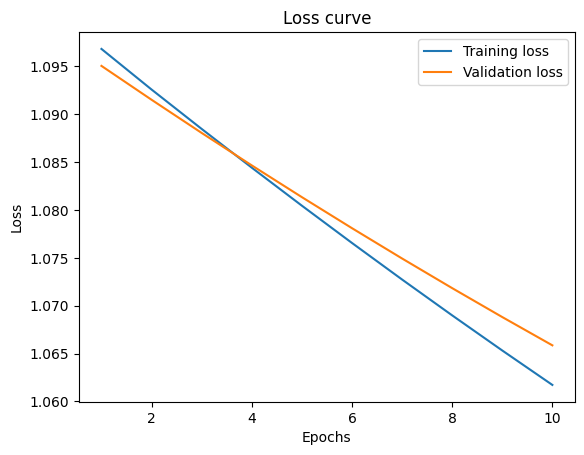

In [10]:
def build_model(num_features, learning_rate):
    """Return a simple logistic regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    
  # Use Keras Sequential API to build a logistic regression
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'))

    # create output layer
    model.add(tf.keras.layers.Dense(
          units=3,  
          use_bias=True,
          activation='softmax',
          kernel_initializer=tf.ones_initializer,
          bias_initializer=tf.ones_initializer,
          name='Output'
    ))
  
  # Use Categorical Crossentropy as our loss and the SGD optimizer.
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

# Build a model
learning_rate = 0.0001
model_tf = build_model(num_features=X_train.shape[1], learning_rate=learning_rate)
model_tf.summary()

# train model
epochs = 10
batch_size = 32

model_fit = model_tf.fit(x=X_train,
                 y=Y_train,
                 validation_data=(X_val, Y_val),
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1
                )

# Plot the loss
train_loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epochs_axis = range(1, epochs+1)
plt.plot(epochs_axis, train_loss, label='Training loss')
plt.plot(epochs_axis, val_loss, label='Validation loss')
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


---
### Step 6: Hyperparameter tuning

### <span style="color:chocolate">Exercise 8:</span> Choosing hyperparameters (10 points)

1. Fine-tune the hyperparameters of *model_tf* to determine the setup that yields the most optimal performance. Feel free to explore various values for the hyperparameters. Hint: ask your instructors and TAs for help if in doubt.

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

First 5 model parameters:
	Non-bias parameters: [[ 0.08838089  0.7465544   1.9123499 ]
 [ 0.7174126  -2.9098423   2.2512312 ]
 [-1.3299837  -1.3534107   3.345931  ]
 [-1.8448801   3.7594354  -1.6300983 ]]
	Bias parameter: [1.0226309 1.2299533 0.5882337]
Final loss amount for training: 0.5108
Final loss amount for validation: 1.3279
Percent difference in traning and validation losses: 159.97%

The logistic model is a significant improvement over the baseline
model. The baseline model is not able to predict any of the examples for
class 0 or class 2 (the minority classes) and is only going to be 57% accurate
in finding the class 1 examples. However, this model has much room for 
improvement



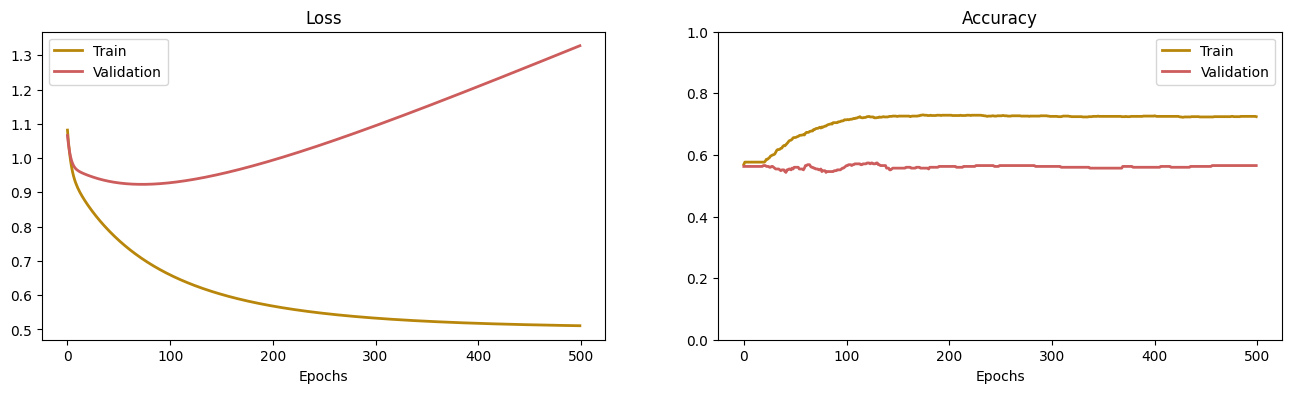

In [11]:
tf.random.set_seed(0)
# Build and compile model
learning_rate = 0.001
epochs = 500

model_tf = build_model(num_features=X_train.shape[1], learning_rate=learning_rate)

# Fit the model
model_fit = model_tf.fit(
    x=X_train,
    y=Y_train,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=0
)

# Print model configuration
train_final_loss = model_fit.history['loss'][epochs-1]
val_final_loss = model_fit.history['val_loss'][epochs-1]
print('First 5 model parameters:')
print('\tNon-bias parameters:', model_tf.layers[0].get_weights()[0][:4])
print('\tBias parameter:', model_tf.layers[0].get_weights()[1])
print(f'Final loss amount for training: {train_final_loss:.4f}')
print(f'Final loss amount for validation: {val_final_loss:.4f}')
print(f'Percent difference in traning and validation losses: {(val_final_loss - train_final_loss) / train_final_loss * 100:.2f}%')

# Answer for compare against baseline
msg = f"""
The logistic model is a significant improvement over the baseline
model. The baseline model is not able to predict any of the examples for
class 0 or class 2 (the minority classes) and is only going to be 57% accurate
in finding the class 1 examples. However, this model has much room for 
improvement
"""
print(msg)

# get history
history = model_fit.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 2, 2)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_ylim([0, 1])
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

---
### Step 7: Evaluation and generalization

### <span style="color:chocolate">Exercise 9:</span> Compute metrics (5 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate aggregate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras. and the <span style="color:chocolate">np.max()</span> method available in NumPy.

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [12]:
### print accuracy for training
Y_train_pred_tf = model_tf.predict(x=X_train)
#print(Y_train_pred_tf[:5])

# set predicted label based on highest probability
Y_train_maxpred_tf =  np.argmax(Y_train_pred_tf, axis=1)

error_train_tf = (Y_train != Y_train_maxpred_tf).sum()/len(Y_train_maxpred_tf)
print(f'Train accuracy = {(1-error_train_tf)*100:.2f}%')

### print accuracy for test
Y_test_pred_tf = model_tf.predict(x=X_test)
#print(Y_test_pred_tf[:5])

# set predicted label based on highest probability
Y_test_maxpred_tf =  np.argmax(Y_test_pred_tf, axis=1)

error_test_tf = (Y_test != Y_test_maxpred_tf).sum()/len(Y_test_maxpred_tf)
print(f'Test accuracy = {(1-error_test_tf)*100:.2f}%')

print("""
2. At this time, the model does not have high accuracy for the Train, Val, or
Test sets. You can see from the 'Loss' graph above that the Loss for Train and 
Validation diverges, with the loss being higher on Validation, demonstrating 
that the model is overfitting for the Train set. Additionally, the accuracy for
the Train set is much higher than test, further demonstrating overfitting.
""")


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train accuracy = 72.61%
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test accuracy = 52.65%

2. At this time, the model does not have high accuracy for the Train, Val, or
Test sets. You can see from the 'Loss' graph above that the Loss for Train and 
Validation diverges, with the loss being higher on Validation, demonstrating 
that the model is overfitting for the Train set. Additionally, the accuracy for
the Train set is much higher than test, further demonstrating overfitting.



### <span style="color:chocolate">Exercise 10:</span> Additional metrics (10 points)

Using the test dataset:

1. Plot the confusion matrix. Identify which class the model confuses the most.

2. Determine which class has the lowest precision. What is the precision? Which class is the largest source of false positives?

3. Determine which class has the lowest recall. What is the recall? Which class is the largest source of false negatives?

Confusion matrix:
tf.Tensor(
[[ 23  57   4]
 [ 37 152  24]
 [  5  43  14]], shape=(3, 3), dtype=int32)


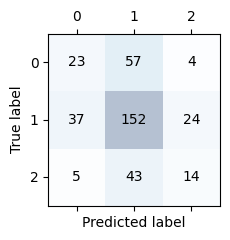

None
Class 0 accuracy =  27.38%
Class 1 accuracy =  71.36%
Class 2 accuracy =  22.58%

1. The model confuses the class 2 or 'high' quality chocolate class the most.
This class has the lowest accuracy with just 22.58% being identified correctly.

Class 0 False Positives = 42
Class 0 False Negatives = 61
Class 0 precision = 0.3538
Class 0 recall = 0.2738
Class 1 False Positives = 100
Class 1 False Negatives = 61
Class 1 precision = 0.6032
Class 1 recall = 0.7136
Class 2 False Positives = 28
Class 2 False Negatives = 48
Class 2 precision = 0.3333
Class 2 recall = 0.2258

2. Class 2 or the 'high' quality class has the lowest precision at 0.3333.
Class 1 or the 'satisfactory' quality class has the most false positives. 


3. Class 2 or the 'high' quality class has the lower recall at 0.2258.
Both Class 0 and Class 1 had the highest number of False Negatives at 61.



In [13]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

# plot confusion matrix for test data
conf_matrix = tf.math.confusion_matrix(
    Y_test,
    Y_test_maxpred_tf,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
print('Confusion matrix:')
print(conf_matrix)

print(confusion_matrix_plot(conf_matrix.numpy()))

# calculate accuracy for each group
class_0_acc = conf_matrix[0][0] / (conf_matrix[0].numpy().sum())
class_1_acc = conf_matrix[1][1] / (conf_matrix[1].numpy().sum())
class_2_acc = conf_matrix[2][2] / (conf_matrix[2].numpy().sum())
print(f'Class 0 accuracy = {class_0_acc * 100: .2f}%')
print(f'Class 1 accuracy = {class_1_acc * 100: .2f}%')
print(f'Class 2 accuracy = {class_2_acc * 100: .2f}%')

print(f"""
1. The model confuses the class 2 or 'high' quality chocolate class the most.
This class has the lowest accuracy with just{class_2_acc * 100: .2f}% being identified correctly.
""")

# calculate TP, FP, FN for classes
class_0_tp = conf_matrix[0][0]
class_0_fp = conf_matrix[1][0] + conf_matrix[2][0]
class_0_fn = conf_matrix[0][1] + conf_matrix[0][2]
class_0_precision = class_0_tp / (class_0_tp + class_0_fp)
class_0_recall = class_0_tp / (class_0_tp + class_0_fn)
print(f'Class 0 False Positives = {class_0_fp}')
print(f'Class 0 False Negatives = {class_0_fn}')
print(f'Class 0 precision = {class_0_precision:.4f}')
print(f'Class 0 recall = {class_0_recall:.4f}')

class_1_tp = conf_matrix[1][1]
class_1_fp = conf_matrix[0][1] + conf_matrix[2][1]
class_1_fn = conf_matrix[1][0] + conf_matrix[1][2]
class_1_precision = class_1_tp / (class_1_tp + class_1_fp)
class_1_recall = class_1_tp / (class_1_tp + class_1_fn)
print(f'Class 1 False Positives = {class_1_fp}')
print(f'Class 1 False Negatives = {class_1_fn}')
print(f'Class 1 precision = {class_1_precision:.4f}')
print(f'Class 1 recall = {class_1_recall:.4f}')

class_2_tp = conf_matrix[2][2]
class_2_fp = conf_matrix[0][2] + conf_matrix[1][2]
class_2_fn = conf_matrix[2][0] + conf_matrix[2][1]
class_2_precision = class_2_tp / (class_2_tp + class_2_fp)
class_2_recall = class_2_tp / (class_2_tp + class_2_fn)
print(f'Class 2 False Positives = {class_2_fp}')
print(f'Class 2 False Negatives = {class_2_fn}')
print(f'Class 2 precision = {class_2_precision:.4f}')
print(f'Class 2 recall = {class_2_recall:.4f}')

print(f"""
2. Class 2 or the 'high' quality class has the lowest precision at {class_2_precision:.4f}.
Class 1 or the 'satisfactory' quality class has the most false positives. 
""")

print(f"""
3. Class 2 or the 'high' quality class has the lower recall at {class_2_recall:.4f}.
Both Class 0 and Class 1 had the highest number of False Negatives at {class_0_fn}.
""")

----
### <span style="color:chocolate">Bonus question</span> (20 points)

Following the approach in Assignment 4 - Exercise 12, evaluate whether your model shows any signs of unfairness. Explain your findings and propose suggestions for improvement.

In [14]:
print("""
I attempted many combinations of features but keeping the classifications the same and all
models performed poorly. I beleive there is a degree of unfairness becuase the 'satisfactory'
class is almost 60% of all the labels. We could try to shift the borders and increase the number
of classes, however, we can see from the histogram of the ratings distribution, that most ratings
are either 3.0, 3.25, or 3.5. It seems that most chocolate is satifactory. It is possible that 
other elements not captured in this dataset would demonstrate much more variance in the distribution
of ratings, and gathering that data could also help improve this model.
""")


I attempted many combinations of features but keeping the classifications the same and all
models performed poorly. I beleive there is a degree of unfairness becuase the 'satisfactory'
class is almost 60% of all the labels. We could try to shift the borders and increase the number
of classes, however, we can see from the histogram of the ratings distribution, that most ratings
are either 3.0, 3.25, or 3.5. It seems that most chocolate is satifactory. It is possible that 
other elements not captured in this dataset would demonstrate much more variance in the distribution
of ratings, and gathering that data could also help improve this model.

